
## Gaussian mixture PHD


In [1]:
# Imports for plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (14, 12)
# Other general imports
import numpy as np
from ordered_set import OrderedSet
from datetime import datetime, timedelta
import itertools

## Generate some sample ground truths

In [2]:
truths_by_time = []

# Create transition model
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity
transition_model = CombinedLinearGaussianTransitionModel(
    (ConstantVelocity(0.3), ConstantVelocity(0.3)))

from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
start_time = datetime.now().replace(microsecond=0)
truths = OrderedSet()  # Truths across all time
current_truths = set()  # Truths alive at current time
start_truths = set()
number_steps = 20
death_probability = 0.005
birth_probability = 0.2
initial_ground_truths = 4

# Initialize truths. This can be changed to any number of truths from variable above.
truths_by_time.append([])
for i in range(initial_ground_truths):
    x, y = initial_position = np.random.uniform(-30, 30, 2)  # Range [-30, 30] for x and y
    x_vel, y_vel = (np.random.rand(2))*2 - 1  # Range [-1, 1] for x and y velocity
    state = GroundTruthState([x, x_vel, y, y_vel], timestamp=start_time)

    truth = GroundTruthPath([state])
    current_truths.add(truth)
    truths.add(truth)
    start_truths.add(truth)
    truths_by_time[0].append(state)

# Simulate the ground truth over time
for k in range(number_steps+1):
    k+=1
    truths_by_time.append([])
    # Death
    for truth in current_truths.copy():
        if np.random.rand() <= death_probability:
            current_truths.remove(truth)
    # Update truths
    
    for truth in current_truths:
        updated_state = GroundTruthState(
            transition_model.function(truth[-1], noise=True, time_interval=timedelta(seconds=1)),
            timestamp=start_time + timedelta(seconds=k))
        truth.append(updated_state)
        # print(len(truth))
        truths_by_time[k].append(updated_state)
    # Birth
    for _ in range(np.random.poisson(birth_probability)):
        x, y = initial_position = np.random.rand(2) * [120, 120]  # Range [0, 20] for x and y
        x_vel, y_vel = (np.random.rand(2))*2 - 1  # Range [-1, 1] for x and y velocity
        state = GroundTruthState([x, x_vel, y, y_vel], timestamp=start_time + timedelta(seconds=k))

        # Add to truth set for current and for all timestamps
        truth = GroundTruthPath([state])
        current_truths.add(truth)
        truths.add(truth)
        truths_by_time[k].append(state)

Plot the ground truth




In [3]:
from stonesoup.plotter import Plotterly, AnimatedPlotterly
plotter = Plotterly()
plotter.plot_ground_truths(truths, [0, 2])
plotter.fig.show()

# Generate timesteps for plotting
timesteps = [start_time + timedelta(seconds=k) for k in range(number_steps)]
print(timesteps)

# # Plotting with AnimatedPlotterly
plotter = AnimatedPlotterly(timesteps, tail_length=0.6)
plotter.plot_ground_truths(truths, [0, 2])  # Plot positions (0 for x and 2 for y)
plotter.fig.show()

[datetime.datetime(2024, 7, 10, 1, 32, 59), datetime.datetime(2024, 7, 10, 1, 33), datetime.datetime(2024, 7, 10, 1, 33, 1), datetime.datetime(2024, 7, 10, 1, 33, 2), datetime.datetime(2024, 7, 10, 1, 33, 3), datetime.datetime(2024, 7, 10, 1, 33, 4), datetime.datetime(2024, 7, 10, 1, 33, 5), datetime.datetime(2024, 7, 10, 1, 33, 6), datetime.datetime(2024, 7, 10, 1, 33, 7), datetime.datetime(2024, 7, 10, 1, 33, 8), datetime.datetime(2024, 7, 10, 1, 33, 9), datetime.datetime(2024, 7, 10, 1, 33, 10), datetime.datetime(2024, 7, 10, 1, 33, 11), datetime.datetime(2024, 7, 10, 1, 33, 12), datetime.datetime(2024, 7, 10, 1, 33, 13), datetime.datetime(2024, 7, 10, 1, 33, 14), datetime.datetime(2024, 7, 10, 1, 33, 15), datetime.datetime(2024, 7, 10, 1, 33, 16), datetime.datetime(2024, 7, 10, 1, 33, 17), datetime.datetime(2024, 7, 10, 1, 33, 18)]


### Generate detections with clutter
Next, generate detections with clutter just as in the previous tutorial. The clutter is
assumed to be uniformly distributed across the entire field of view, here assumed to
be the space where $x \in [-200, 200]$ and $y \in [-200, 200]$.



In [4]:
# Make the measurement model
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(
    ndim_state=4,
    mapping=(0, 2),
    noise_covar=np.array([[0.75, 0],
                          [0, 0.75]])
    )

# Generate detections and clutter
from scipy.stats import uniform

from stonesoup.types.detection import TrueDetection
from stonesoup.types.detection import Clutter

all_measurements = []
# The probability detection and clutter rate play key roles in the posterior intensity.
# They can be changed to see their effect.
probability_detection = 0.8
clutter_rate = 7.0

for k in range(number_steps):
    measurement_set = set()
    timestamp = start_time + timedelta(seconds=k)

    for truth in truths:
        try:
            truth_state = truth[timestamp]
        except IndexError:
            # This truth not alive at this time. Skip this iteration of the for loop.
            continue

        # Generate actual detection from the state with a 10% chance that no detection is received.
        if np.random.rand() <= probability_detection:
            # Generate actual detection from the state
            measurement = measurement_model.function(truth_state, noise=True)
            measurement_set.add(TrueDetection(state_vector=measurement,
                                              groundtruth_path=truth,
                                              timestamp=truth_state.timestamp,
                                              measurement_model=measurement_model))

    # Generate clutter at this time-step
    for _ in range(np.random.poisson(clutter_rate)):
        x = uniform.rvs(-200, 400)
        y = uniform.rvs(-200, 400)
        measurement_set.add(Clutter(np.array([[x], [y]]), timestamp=timestamp,
                                    measurement_model=measurement_model))

    all_measurements.append(measurement_set)



# Plot true detections and clutter.
plotter.plot_measurements(all_measurements, [0, 2])
plotter.fig

In [5]:
from stonesoup.updater.kalman import KalmanUpdater
kalman_updater = KalmanUpdater(measurement_model)

# Area in which we look for target. Note that if a target appears outside of this area the
# filter will not pick up on it.
meas_range = np.array([[-1, 1], [-1, 1]])*200
clutter_spatial_density = clutter_rate/np.prod(np.diff(meas_range))

from stonesoup.updater.pointprocess import PHDUpdater
updater = PHDUpdater(
    kalman_updater,
    clutter_spatial_density=clutter_spatial_density,
    prob_detection=probability_detection,
    prob_survival=1-death_probability)

In [6]:
from stonesoup.predictor.kalman import KalmanPredictor
kalman_predictor = KalmanPredictor(transition_model)

from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis
base_hypothesiser = DistanceHypothesiser(kalman_predictor, kalman_updater, Mahalanobis(), missed_distance=3)

from stonesoup.hypothesiser.gaussianmixture import GaussianMixtureHypothesiser
hypothesiser = GaussianMixtureHypothesiser(base_hypothesiser, order_by_detection=True)

from stonesoup.mixturereducer.gaussianmixture import GaussianMixtureReducer
# Initialise a Gaussian Mixture reducer
merge_threshold = 5     # Threshold Squared Mahalanobis distance
prune_threshold = 1E-8  # Threshold component weight

reducer = GaussianMixtureReducer(
    prune_threshold=prune_threshold,
    pruning=True,
    merge_threshold=merge_threshold,
    merging=True)

from stonesoup.types.state import TaggedWeightedGaussianState
from stonesoup.types.track import Track
from stonesoup.types.array import CovarianceMatrix
covar = CovarianceMatrix(np.diag([10, 5, 10, 5]))

tracks = set()
reduced_states = set([track[-1] for track in tracks])
# for truth in start_truths:
#     new_track = TaggedWeightedGaussianState(
#             state_vector=truth.state_vector,
#             covar=covar**2,
#             weight=0.25,
#             tag=TaggedWeightedGaussianState.BIRTH,
#             timestamp=start_time)
#     tracks.add(Track(new_track))

birth_covar = CovarianceMatrix(np.diag([1000, 2, 1000, 2]))
birth_component = TaggedWeightedGaussianState(
    state_vector=[0, 0, 0, 0],
    covar=birth_covar**2,
    weight=0.25,
    tag='birth',
    timestamp=start_time
)

all_gaussians = []
tracks_by_time = []

In [7]:
state_threshold = 0.25

for n, measurements in enumerate(all_measurements):
    tracks_by_time.append([])
    all_gaussians.append([])

    # The hypothesiser takes in the current state of the Gaussian mixture. This is equal to the list of
    # reduced states from the previous iteration. If this is the first iteration, then we use the priors
    # defined above.
    current_state = reduced_states

    # At every time step we must add the birth component to the current state
    if measurements:
        time = list(measurements)[0].timestamp
    else:
        time = start_time + timedelta(seconds=n)
    birth_component.timestamp = time
    current_state.add(birth_component)

    # Generate the set of hypotheses
    hypotheses = hypothesiser.hypothesise(current_state,
                                          measurements,
                                          timestamp=time,
                                          # keep our hypotheses ordered by detection, not by track
                                          order_by_detection=True)

    # Turn the hypotheses into a GaussianMixture object holding a list of states
    updated_states = updater.update(hypotheses)

    # Prune and merge the updated states into a list of reduced states
    reduced_states = set(reducer.reduce(updated_states))

    # Add the reduced states to the track list. Each reduced state has a unique tag. If this tag matches the tag of a
    # state from a live track, we add the state to that track. Otherwise, we generate a new track if the reduced
    # state's weight is high enough (i.e. we are sufficiently certain that it is a new track).
    for reduced_state in reduced_states:
        # Add the reduced state to the list of Gaussians that we will plot later. Have a low threshold to eliminate some
        # clutter that would make the graph busy and hard to understand
        if reduced_state.weight > 0.05: all_gaussians[n].append(reduced_state)

        tag = reduced_state.tag
        # Here we check to see if the state has a sufficiently high weight to consider being added.
        if reduced_state.weight > state_threshold:
            # Check if the reduced state belongs to a live track
            for track in tracks:
                track_tags = [state.tag for state in track.states]

                if tag in track_tags:
                    track.append(reduced_state)
                    tracks_by_time[n].append(reduced_state)
                    break
            else:  # Execute if no "break" is hit; i.e. no track with matching tag
                # Make a new track out of the reduced state
                new_track = Track(reduced_state)
                tracks.add(new_track)
                tracks_by_time[n].append(reduced_state)

### Plot the Tracks
First, determine the x and y range for axes. We want to zoom in as much as possible
on the measurements and tracks while not losing any of the information. This section
is not strictly necessary as we already set the field of view to be the range [-100, 100]
for both x and y. However, sometimes an object may leave the field of view. If you want
to ignore objects that have left the field of view, comment out this section and define
the variables
`x_min` = `y_min` = -100 and `x_max` = `y_max` = 100.



In [8]:
x_min, x_max, y_min, y_max = 0, 0, 0, 0

# Get bounds from the tracks
for track in tracks:
    for state in track:
        x_min = min([state.state_vector[0], x_min])
        x_max = max([state.state_vector[0], x_max])
        y_min = min([state.state_vector[2], y_min])
        y_max = max([state.state_vector[2], y_max])

# Get bounds from measurements
for measurement_set in all_measurements:
    for measurement in measurement_set:
        if type(measurement) == TrueDetection:
            x_min = min([measurement.state_vector[0], x_min])
            x_max = max([measurement.state_vector[0], x_max])
            y_min = min([measurement.state_vector[1], y_min])
            y_max = max([measurement.state_vector[1], y_max])

Now we can use the :class:`~.Plotter` class to draw the tracks. Note that if the birth
component it plotted you will see its uncertainty ellipse centred around $(0, 0)$.
This ellipse need not cover the entire state space, as long as the distribution does.



In [9]:
# Plot the tracks
plotter = Plotterly()
plotter.plot_ground_truths(truths, [0, 2])
plotter.plot_measurements(all_measurements, [0, 2])
plotter.plot_tracks(tracks, [0, 2], uncertainty=True)
plotter.fig.update_xaxes(range=[x_min-5, x_max+5])
plotter.fig.update_yaxes(range=[y_min-5, y_max+5])
plotter.fig

### Examining the Gaussian Mixtures
At every time step, the above GM-PHD algorithm creates a Gaussian mixture, which is
a distribution over our target space. The following sections take a closer look at what
this Gaussian really looks like. Note that the figures below only include the reduced
states which have weight greater than 0.05. This decreases the overall number of states
shown in the mixture and makes it easier to examine. But you can change this threshold
parameter in the Run The Tracker section.

First we define a function that will help generate the z values for the Gaussian
mixture. This lets us plot it later. This function has been updated from the one
found [here](https://notebook.community/empet/Plotly-plots/Gaussian-Mixture) from
[this](https://github.com/empet/Plotly-plotse) GPL-3.0 licensed repository.




In [10]:
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def get_mixture_density(x, y, weights, means, sigmas):
    # We use the quantiles as a parameter in the multivariate_normal function. We don't need to pass in any quantiles,
    # but the last axis must have the components x and y
    quantiles = np.empty(x.shape + (2,))  # if  x.shape is (m,n) then quantiles.shape is (m,n,2)
    quantiles[:, :, 0] = x
    quantiles[:, :, 1] = y

    # Go through each gaussian in the list and add its PDF to the mixture
    z = np.zeros(x.shape)
    for gaussian in range(len(weights)):
        z += weights[gaussian]*multivariate_normal.pdf(x=quantiles, mean=means[gaussian, :], cov=sigmas[gaussian])
    return z

For each timestep, create a new figure with 2 subplots. The plot on the left will
show the 3D Gaussian Mixture density. The plot on the right will show a 2D
birds-eye-view of the space, including the ground truths, detections, clutter, and tracks.



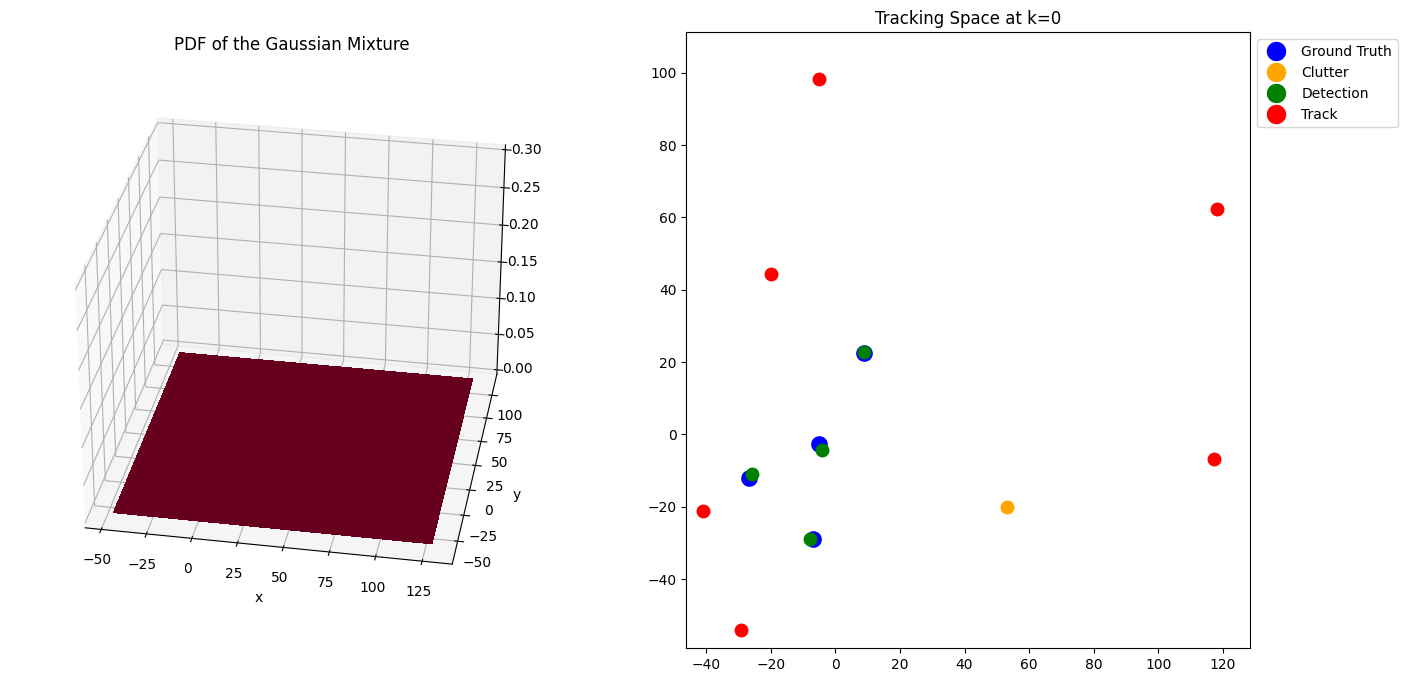

In [11]:
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D  # Will be used when making the legend

# This is the function that updates the figure we will be animating. As parameters we must
# pass in the elements that will be changed, as well as the index i
def animate(i, sf, truths, tracks, measurements, clutter):
    # Set up the axes
    axL.clear()
    axR.set_title('Tracking Space at k='+str(i))
    axL.set_xlabel("x")
    axL.set_ylabel("y")
    axL.set_title('PDF of the Gaussian Mixture')
    axL.view_init(elev=30, azim=-80)
    axL.set_zlim(0, 0.3)

    # Initialize the variables
    weights = []  # weights of each Gaussian. This is analogous to the probability of its existence
    means = []    # means of each Gaussian. This is equal to the x and y of its state vector
    sigmas = []   # standard deviation of each Gaussian.

    # Fill the lists of weights, means, and standard deviations
    for state in all_gaussians[i]:
        weights.append(state.weight)
        means.append([state.state_vector[0], state.state_vector[2]])
        sigmas.append([state.covar[0][0], state.covar[1][1]])
    means = np.array(means)
    sigmas = np.array(sigmas)

    # Generate the z values over the space and plot on the left axis
    zarray[:, :, i] = get_mixture_density(x, y, weights, means, sigmas)
    sf = axL.plot_surface(x, y, zarray[:, :, i], cmap=cm.RdBu, linewidth=0, antialiased=False)

    # Make lists to hold the new ground truths, tracks, detections, and clutter
    new_truths, new_tracks, new_measurements, new_clutter = [], [], [], []
    for truth in truths_by_time[i]:
        new_truths.append([truth.state_vector[0], truth.state_vector[2]])
    for state in tracks_by_time[i]:
        new_tracks.append([state.state_vector[0], state.state_vector[2]])
    for measurement in all_measurements[i]:
        if isinstance(measurement, TrueDetection):
            new_measurements.append([measurement.state_vector[0], measurement.state_vector[1]])
        elif isinstance(measurement, Clutter):
            new_clutter.append([measurement.state_vector[0], measurement.state_vector[1]])

    # Plot the contents of these lists on the right axis
    if new_truths:
        truths.set_offsets(new_truths)
    if new_tracks:
        tracks.set_offsets(new_tracks)
    if new_measurements:
        measurements.set_offsets(new_measurements)
    if new_clutter:
        clutter.set_offsets(new_clutter)

    # Create a legend. The use of Line2D is purely for the visual in the legend
    data_types = [Line2D([0], [0], color='white', marker='o', markerfacecolor='blue', markersize=15,
                         label='Ground Truth'),
                  Line2D([0], [0], color='white', marker='o', markerfacecolor='orange', markersize=15,
                         label='Clutter'),
                  Line2D([0], [0], color='white', marker='o', markerfacecolor='green', markersize=15,
                         label='Detection'),
                  Line2D([0], [0], color='white', marker='o', markerfacecolor='red', markersize=15,
                         label='Track')]
    axR.legend(handles=data_types, bbox_to_anchor=(1.0, 1), loc='upper left')

    return sf, truths, tracks, measurements, clutter

# Set up the x, y, and z space for the 3D axis
xx = np.linspace(x_min-5, x_max+5, 100)
yy = np.linspace(y_min-5, y_max+5, 100)
x, y = np.meshgrid(xx, yy)
zarray = np.zeros((100, 100, number_steps))

# Create the matplotlib figure and axes. Here we will have two axes being animated in sync.
# `axL` will be the a 3D axis showing the Gaussian mixture
# `axR` will be be a 2D axis showing the ground truth, detections, and updated tracks at
# each time step.
fig = plt.figure(figsize=(16, 8))
axL = fig.add_subplot(121, projection='3d')
axR = fig.add_subplot(122)
axR.set_xlim(x_min-5, x_max+5)
axR.set_ylim(y_min-5, y_max+5)

# Add an initial surface to the left axis and scattered points on the right axis. Doing
# this now means that in the animate() function we only have to update these variables
sf = axL.plot_surface(x, y, zarray[:, :, 0], cmap=cm.RdBu, linewidth=0, antialiased=False)
truths = axR.scatter(x_min-10, y_min-10, c='blue', linewidth=6, zorder=0.5)
tracks = axR.scatter(x_min-10, y_min-10, c='red', linewidth=4, zorder=1)
measurements = axR.scatter(x_min-10, y_min-10, c='green', linewidth=4, zorder=0.5)
clutter = axR.scatter(x_min-10, y_min-10, c='orange', linewidth=4, zorder=0.5)

# Create and display the animation
from matplotlib import rc
anim = animation.FuncAnimation(fig, animate, frames=number_steps, interval=500,
                               fargs=(sf, truths, tracks, measurements, clutter), blit=False)
rc('animation', html='jshtml')
anim

## References
.. [#] B. Vo and W. Ma, "The Gaussian Mixture Probability Hypothesis Density Filter," in IEEE
       Transactions on Signal Processing, vol. 54, no. 11, pp. 4091-4104, Nov. 2006, doi:
       10.1109/TSP.2006.881190

.. [#] D. E. Clark, K. Panta and B. Vo, "The GM-PHD Filter Multiple Target Tracker," 2006 9th
       International Conference on Information Fusion, 2006, pp. 1-8, doi: 10.1109/ICIF.2006.301809

.. [#] B. Ristic, D. Clark, B. Vo and B. Vo, "Adaptive Target Birth Intensity for PHD and CPHD
       Filters," in IEEE Transactions on Aerospace and Electronic Systems, vol. 48, no. 2, pp.
       1656-1668, Apr 2012, doi: 10.1109/TAES.2012.6178085

